# Load libraries

In [83]:
import os

import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import matplotlib.colors as mcolors

import numpy as np
from scipy import interpolate

import json

# Load base prices, manual inputs...

In [68]:
# Load good prices (base, max and min) list
with open('goodPrices.json', 'r') as f:
    goodsPrices = json.load(f)

# Load available factories
with open('factories.json', 'r') as f:
    factories = json.load(f)

# Load manual inputs
with open('inputs.json', 'r') as f:
    inputs = json.load(f)
inputs['ratioCraftsmen'] = inputs['Ncraftsmen']/inputs['factoryLevel']/10000
if inputs['ratioCraftsmen']>0.8: inputs['ratioCraftsmen'] = 0.8

inputs['ratioClerks'] = inputs['Nclerks']/inputs['factoryLevel']/10000
if inputs['ratioClerks']>0.2: inputs['ratioClerks'] = 0.2

inputs['ratioCapitalists'] = inputs['Ncapitalists']/inputs['statePops']

inputs['infrastructureLvL'] = inputs['infrastructureLvL']/100+1
inputs['inputEfficiency'] = inputs['inputEfficiency']/100
inputs['outputEfficiency'] = inputs['outputEfficiency']/100+1
inputs['throughput'] = inputs['throughput']/100+1
inputs['localThroughput'] = inputs['localThroughput']/100+1
inputs['factoryRGObonus'] = inputs['factoryRGObonus']/100+1
inputs['maintenanceGoods'] = inputs['maintenanceGoods']/100
inputs['employment'] = inputs['employment']/100

needsFactor = inputs['ratioCraftsmen']*0.4*inputs['throughput']*inputs['localThroughput']*inputs['factoryRGObonus']
needsFactor *= (1-2.5*inputs['ratioCapitalists']/inputs['statePops']-inputs['inputEfficiency'])
prodFactor = inputs['ratioCraftsmen']*0.4*inputs['throughput']*inputs['localThroughput']*inputs['factoryRGObonus']
prodFactor *= (1+inputs['ratioClerks']*1.5)*inputs['outputEfficiency']*(0.75+0.25*inputs['maintenanceGoods'])

# Load savegame

In [69]:
# directory = 'savegames/'
# for file in os.listdir(directory):
#     if file.endswith('.v2'):
#         print(os.path.join(directory, file))

# Ideally, I guess we want to integrate this into a web app, so there is no point to make the file selection part. Hardcoded for now
fileloc = 'savegames/testsave.v2'
with open(fileloc, 'r') as file:
    contents = file.read().splitlines()

# Parse savegame
date = contents[0].split('"')[1]
country = contents[1].split('"')[1]
for index, line in enumerate(contents):
    if line.startswith('worldmarket'):
        worldmarket = {}
        i=1
        n=1
        while True:
            i+=1
            string = contents[index+i]
            if string[-1] == '}': break
            elif string.startswith('\tprice_history_last_update'): 
                pricedate = string.split('"')[1]
                continue

            name = string.split('\t')[1].split('=')[0]
            if name == 'price_history' and name in worldmarket: 
                name+=str(n)
                n+=1
            worldmarket[name] = {}
            i+=1
            while True:
                i+=1
                string = contents[index+i]
                #print(string)
                if string[-1] == '}': break

                string = string.split('\t\t')[1].split('=')
                worldmarket[name][string[0]] = float(string[1])
            

    elif line.startswith('budget_balance'):
        budget_balance = np.array([float(x) for x in contents[index+2].split('\t')[1].split(' }')[0].split(' ')])

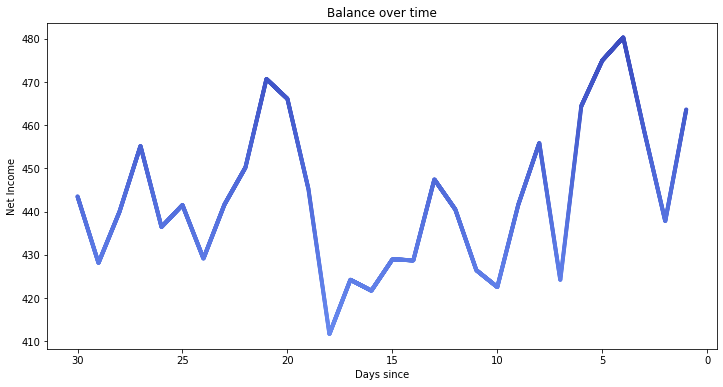

In [70]:
days = list(range(len(budget_balance),0,-1))
plotted_days = np.linspace(1,30,5000)
plotted_bal = interpolate.interp1d(days, budget_balance)(plotted_days)
colors = [cmap.coolwarm_r(x) for x in plotted_bal/max(abs(budget_balance))]

plt.figure(figsize=(12,6))
plt.scatter(plotted_days, plotted_bal, color=colors, marker='.')
plt.ylabel('Net Income')
plt.xlabel('Days since')
plt.title(f'Balance over time')
plt.gca().invert_xaxis()
plt.show()

# Compute factory profitability

In [71]:
schemes = {
    'Base_prices': {
        'buy': lambda goody: goodsPrices[goody],
        'sell': lambda goody: goodsPrices[goody]
    },
    'Worst_case': {
        'buy': lambda goody: goodsPrices[goody]*2,
        'sell': lambda goody: goodsPrices[goody]/2
    },
    'Best_case': {
        'buy': lambda goody: goodsPrices[goody]/2,
        'sell': lambda goody: goodsPrices[goody]*2
    },
    'Actual_prices': {
        'buy': lambda goody: worldmarket['price_pool'][goody],
        'sell': lambda goody: worldmarket['price_pool'][goody]
    }
}

def profitfunc(factory, buyfunc, sellfunc):
    inputCost = 0
    for good in factories[factory]['baseInput']:
        amount = factories[factory]['baseInput'][good]
        price = buyfunc(good)
        inputCost += amount*price*needsFactor
        
    outputValue = 0
    for good in factories[factory]['baseOutput']:
        amount = factories[factory]['baseOutput'][good]
        price = sellfunc(good)
        outputValue += amount*price*prodFactor

    for good in factories[factory]['maintenance']:
        amount = 0.363*inputs['factoryLevel']*factories[factory]['maintenance'][good]*inputs['employment']
        price = buyfunc(good)
        inputCost += amount*price
    return (outputValue/inputCost-1)*100

In [80]:
ordered = {}
for factory in factories:
    factoryName = factory.replace('_',' ').capitalize().replace(' factory','')
    
    for scheme in schemes:
        schemeName = scheme.replace('_',' ')
        buyingPrice = schemes[scheme]['buy']
        sellingPrice = schemes[scheme]['sell']

        profitability = profitfunc(factory, buyingPrice, sellingPrice)
        #print(f'Profitability of {factoryName}, under {schemeName} scenario: {profitability:.2f}%')
    ordered[factoryName] = profitability
ordered = dict(sorted(ordered.items(), key=lambda item: -item[1]))

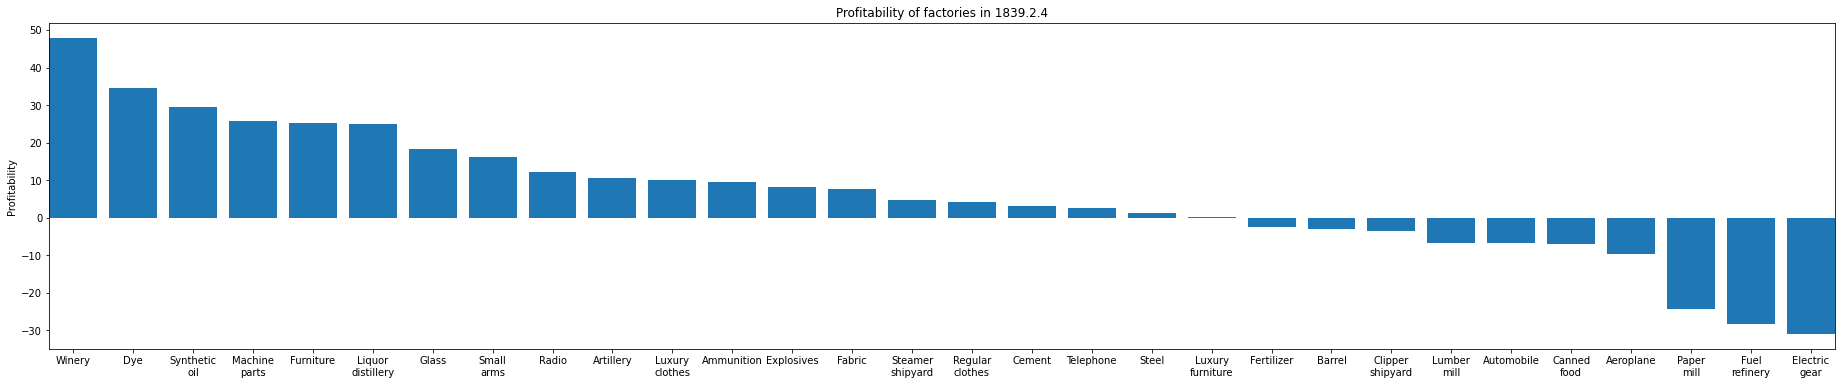

In [81]:
names = [ x.replace(' ','\n') for x in ordered.keys()]
plt.figure(figsize=(32,6))
plt.bar(names,list(ordered.values()))
plt.ylabel('Profitability')
plt.title(f'Profitability of factories in {date}')
plt.margins(x=0)
plt.show()

In [99]:
def multiplePlot(
    nplots: int,
    func,
    figscale: float = 1,
    xlabel=None,
    ylabel=None,
) -> plt.Axes:
    """
    ## **Multiple plots**

    #### Inputs
    ###### nplots : int
        Total number of plots in figure
    ###### func : Callable function
        Function that takes the subplot's id (i, axes, figure) and makes the necessary graphs

    #### Additional inputs
    ###### figscale : float
    ###### xlabel : string
    ###### ylabel : string

    #### Outputs
        Figure
    <hr style="border:4px solid blue"> </hr> <br />
    """
    
    x = int(np.ceil(nplots / 3))
    fig, ax = plt.subplots(x, 3, figsize=(18*figscale, 4.5*figscale*x))

    for i, axes in enumerate(ax.flatten()):
        if i % 3 == 0:
            plt.setp(axes, ylabel=ylabel)
        if i >= nplots - 3:
            plt.setp(axes, xlabel=xlabel)

        if i >= nplots:
            fig.delaxes(axes)
            continue

        ##
        func(i,axes,fig)
        ##

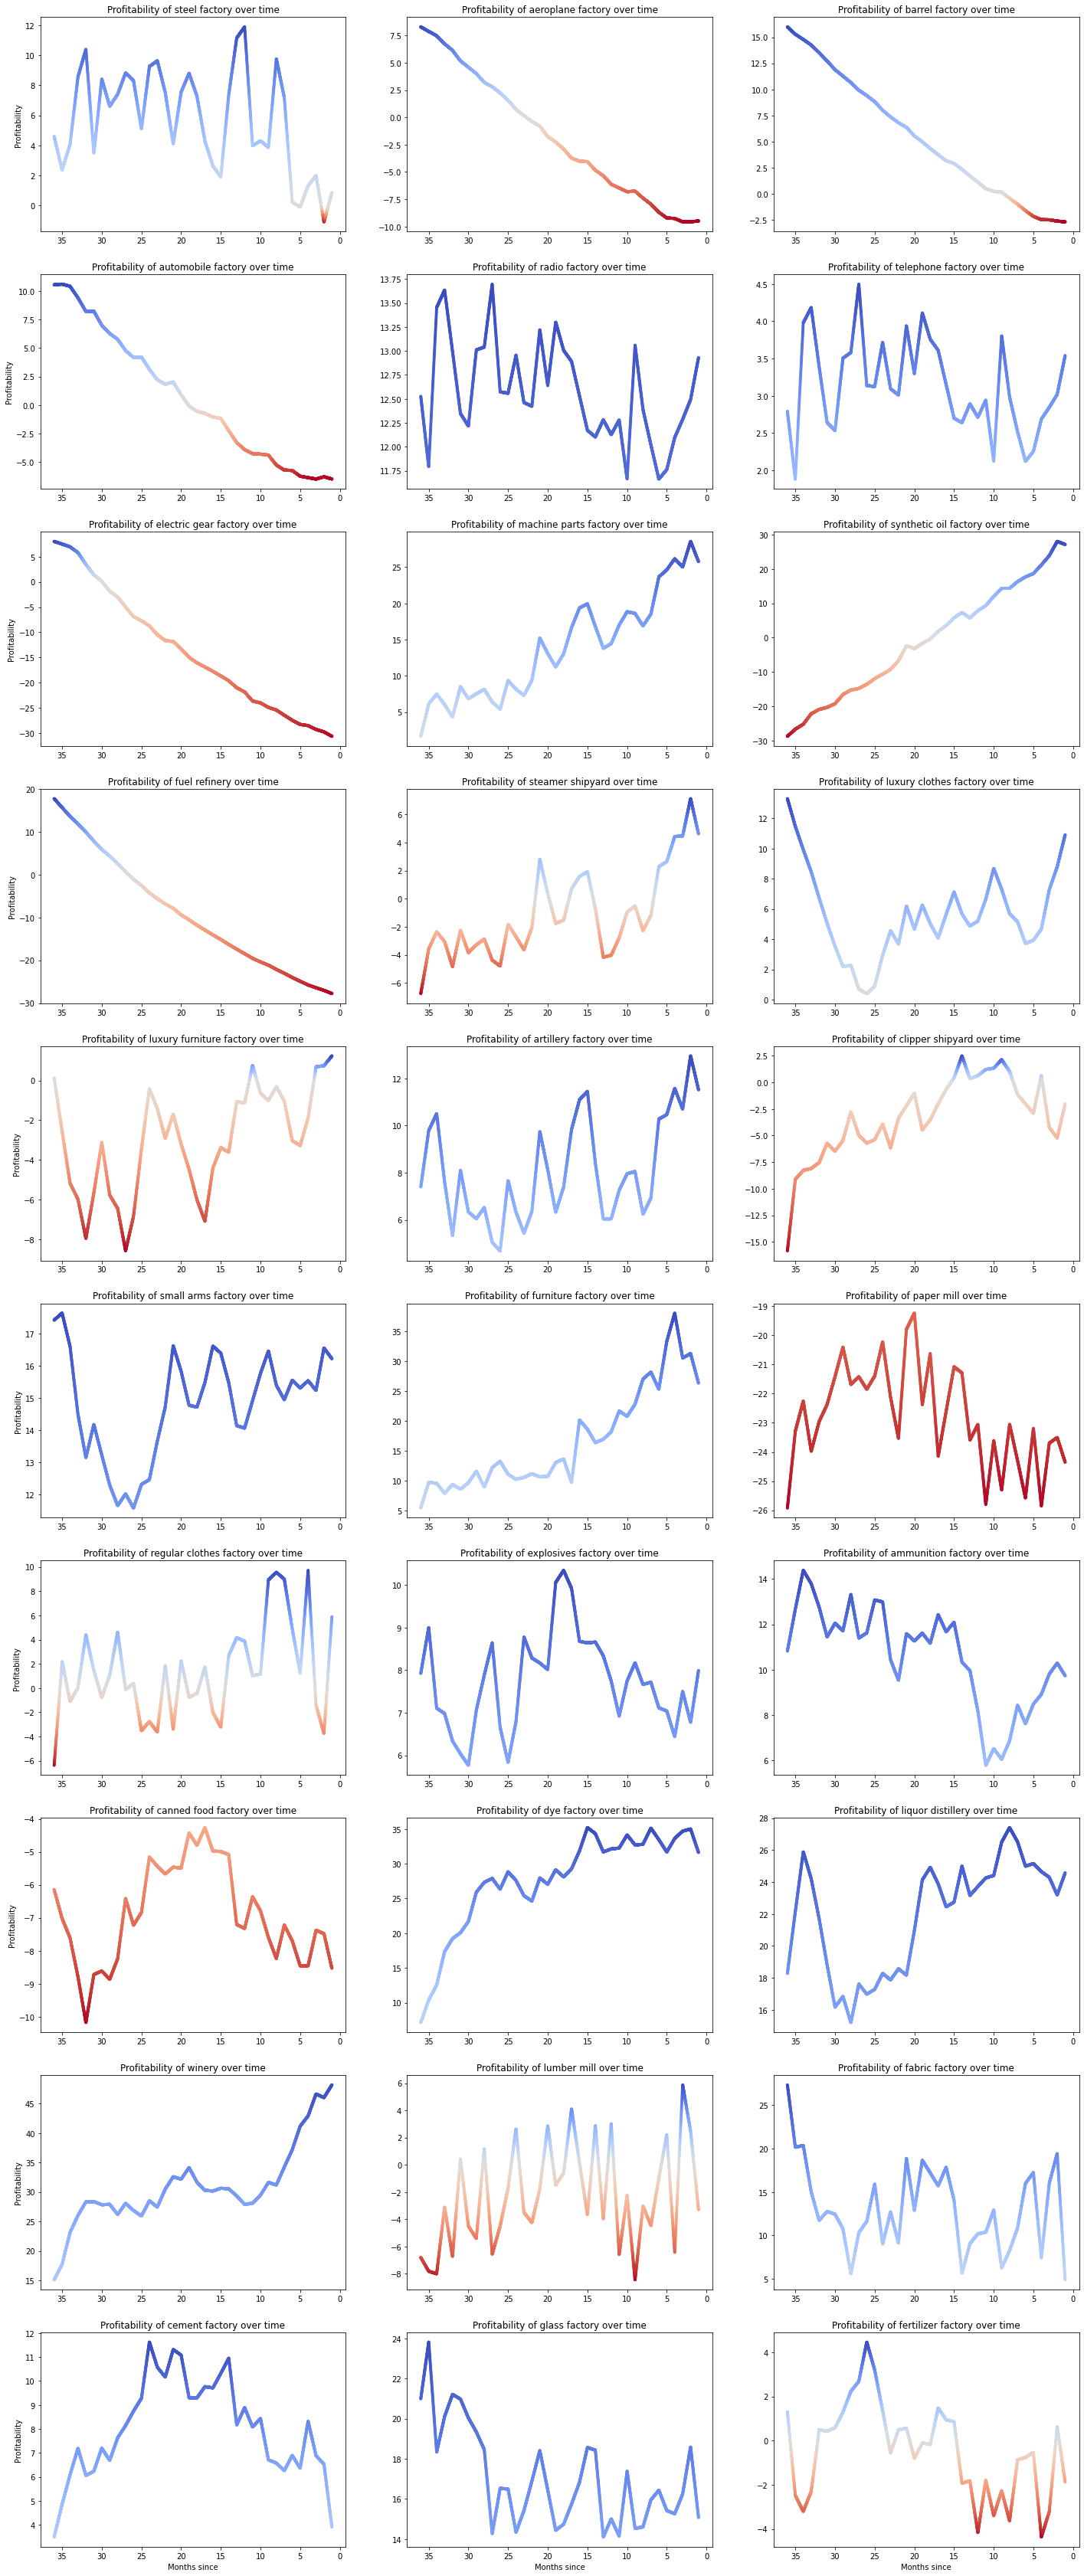

In [110]:
nlabels = len(factories)
x = []
y = []
colors = []
names = []

for i,factory in enumerate(factories):
    factoryName = factory.replace('_',' ')
    n = 0
    months = []
    profits = []
    for key in worldmarket:
        if key.startswith('price_history'):
            n+=1
            months.append(n)
            buyingPrice = lambda goody: worldmarket[key][goody]
            sellingPrice = lambda goody: worldmarket[key][goody]

            profits.append(profitfunc(factory, buyingPrice, sellingPrice))

    months = np.array(months)
    months = -months+max(months)+1
    plotted_months = np.linspace(n,1,3000)
    plotted_profits = interpolate.interp1d(months, profits)(plotted_months)

    norm = mcolors.TwoSlopeNorm(vmin=min(min(profits),-0.01), vcenter=0., vmax=max(0.01,max(profits)))
    colors.append([ cmap.coolwarm_r(norm(x)) for x in plotted_profits])
    x.append(plotted_months)
    y.append(plotted_profits)
    names.append(factoryName)
    

def func(i,axes,fig):

    axes.scatter(x[i], y[i], color=colors[i], marker='.')
    axes.set_title(f'Profitability of {names[i]} over time')
    axes.invert_xaxis()

multiplePlot(nlabels, func, figscale=1.35, xlabel='Months since', ylabel='Profitability')
plt.savefig('factoriesOvertime.jpg')
plt.show()